**Problem Statement**

**`A retail company "ABC Private Limited" wants to understand the customer purchase behaviour (specifically, purchase amount) against various products of different categories. They have shared purchase summary of various customers for selected high volume products from last month. The dataset also contains customer demographics (age, gender, marital status, city_type, stay_in_current_city), product details (product_id and product category) and Total purchase_amount from last month.`**

**Objective**

**`To build a model to predict the purchase amount of customers against various products which will help them to create personlised offer for customers against different products`**

**Evaluation Metric:** **`Root mean Squard score (RMSE)`**

**Variable Definitions**

                        1.  User_ID                             User ID
                        2.  Product_ID                          Product_ID
                        3.  Gender                              Sex of User
                        4.  Age                                 Age in Bins
                        5.  Occupation                          Occupation(Masked)
                        6.  City_category                       Category of the city (A,B,C)
                        7.  Stay_in_current_city_years          Number of years stayed in current city
                        8.  Marital_Status                      Marital Status
                        9.  Product_Category_1                  Product Category (Masked)
                        10. Product_Category_2                  Product may belong to other Category (Masked)
                        11. Product_Category_3                  Product may belong to other Category (Masked)
                        12. Purchase                            Purchase Amount (Target Variable)

In [1]:
path = "C:/Machine_learning_datafiles/AnalyticsVidya/Black Friday sales"

In [2]:
import os, gc, warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
import missingno as msno

In [232]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score
import catboost as cat
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

In [5]:
plt.style.use('ggplot')
pd.set_option('display.max_columns', 100)
%matplotlib inline

In [6]:
#for reproducibility
import random
seed= 42
random.seed(seed)
np.random.seed(seed)

In [90]:
#importing data
train = pd.read_csv(path+'/Train.csv')
test = pd.read_csv(path+'/Test.csv')
subfile = pd.read_csv(path+'/Sample_Submission.csv')

In [8]:
train.shape, test.shape

((550068, 12), (233599, 11))

In [9]:
train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [10]:
test.head(3)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
0,1000004,P00128942,M,46-50,7,B,2,1,1,11.0,NaN
1,1000009,P00113442,M,26-35,17,C,0,0,3,5.0,NaN
2,1000010,P00288442,F,36-45,1,B,4+,1,5,14.0,NaN


In [11]:
train.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,376430.000000,166821.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9.842329,12.668243,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5.086590,4.125338,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


In [12]:
test.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
count,2.335990e+05,233599.000000,233599.000000,233599.000000,161255.000000,71037.000000
mean,1.003029e+06,8.085407,0.410070,5.276542,9.849586,12.669454
std,1.726505e+03,6.521146,0.491847,3.736380,5.094943,4.125944
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000
25%,1.001527e+06,2.000000,0.000000,1.000000,5.000000,9.000000
50%,1.003070e+06,7.000000,0.000000,5.000000,9.000000,14.000000
75%,1.004477e+06,14.000000,1.000000,8.000000,15.000000,16.000000
max,1.006040e+06,20.000000,1.000000,18.000000,18.000000,18.000000


In [13]:
train.dtypes

User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                        int64
dtype: object

`In filling in missing values we will replace null values with -1, signifying None (No subcategories)`

In [189]:
train.fillna(-1, inplace=True)
test.fillna(-1, inplace=True)

In [15]:
train.Age.unique(), train.Stay_In_Current_City_Years.unique()

(array(['0-17', '55+', '26-35', '46-50', '51-55', '36-45', '18-25'],
       dtype=object),
 array(['2', '4+', '3', '1', '0'], dtype=object))

In [91]:
age_map = {
    '0-17' : 1, '18-25' : 2, '26-35' : 3, '36-45' : 4, '46-50' : 5, '51-55' : 6, '55+' : 7
}

residency_map = {
    '0' : 1, '1' : 2, '2' : 3, '3' : 4, '4+' : 5
}

In [92]:
train.Age = train.Age.map(age_map)
test.Age = test.Age.map(age_map)
train.Stay_In_Current_City_Years = train.Stay_In_Current_City_Years.map(residency_map)
test.Stay_In_Current_City_Years = test.Stay_In_Current_City_Years.map(residency_map)

In [95]:
lb_enc = LabelEncoder()

In [96]:
train.dtypes[train.dtypes == 'object'].index

Index(['Product_ID', 'Gender', 'City_Category', 'ProductID_Category'], dtype='object')

In [97]:
for col in ['Product_ID', 'Gender', 'City_Category', 'User_ID']:
    df = train.append(test)[col]
    lb_enc.fit(df)
    train[col] = lb_enc.transform(train[col])
    test[col] = lb_enc.transform(test[col])

In [200]:
X = train.drop('Purchase', axis=1).astype('float32')
y= train.Purchase

test_c = test.copy()

In [201]:
xtrainval, xtest, ytrainval, ytest = train_test_split(X, y, test_size=0.15, random_state=seed, stratify=X.User_ID)

In [202]:
xtrain, xval, ytrain, yval = train_test_split(xtrainval, ytrainval, test_size=0.25, random_state=seed, 
                                              stratify=xtrainval.User_ID)

In [203]:
xtrain.shape, xval.shape, xtest.shape

((350667, 12), (116890, 12), (82511, 12))

In [182]:
def modeleval(model, x, y)->float:
    return mean_squared_error(y, np.clip(model.predict(x),0,None), squared=False)#clipping -ve values to zero

In [79]:
def trainModel(model):
    model.fit(xtrain, ytrain, eval_set= [(xtrain, ytrain), (xval, yval)], 
              early_stopping_rounds=300, verbose=500)
    return model

In [60]:
def kfoldScores(model, cv=5):
    cvs = np.sqrt(-cross_val_score(model, xtrainval, ytrainval, scoring='neg_mean_squared_error', cv=cv))
    cvs_mean = round(np.mean(cvs), 3)
    cvs_std = round(np.std(cvs), 3)
    return str(cvs_mean)+' +- '+str(cvs_std)

In [186]:
def Predictions(model, X, y):
    tr_avg, val_avg = 0,0
    tr_preds = np.zeros(len(X))
    test_predictions= []
    
    for fold_, (tr_, val_) in enumerate(kfold.split(X,y), start=1):
        xtrain, ytrain = X.iloc[tr_], y.iloc[tr_]
        xval, yval = X.iloc[val_] , y.iloc[val_]
        model.fit(xtrain, ytrain, eval_set=[(xval, yval)], 
                  early_stopping_rounds=300, verbose=False)
        tr_rmse = modeleval(model, xtrain, ytrain)
        val_rmse = modeleval(model, xval, yval)
        print('Train RMSE: {:.4f}, Val RMSE: {:.4f}'.format(tr_rmse, val_rmse))
        
        #rmse
        tr_avg+=tr_rmse
        val_avg+=val_rmse
        
        tr_preds[val_] = np.clip(model.predict(xval), 0, None)
        test_pred = np.clip(model.predict(test_c), 0, None)
        test_predictions.append(test_pred)
    print('AVG Train RMSE: {:.4f} AVG Val RMSE: {:.4f}'.format(tr_avg/fold_, val_avg/fold_))
    return np.mean(test_predictions, 0).astype('float32'), tr_preds.astype('float32')

In [233]:
def StackModels(meta_etimator, train_stack, test_stack, target):
    pred = meta_etimator.fit(train_stack, target).predict(test_stack)
    pred = np.clip(pred, 0, None)
    return pred

In [86]:
def plotImportance(model):
    return pd.Series(model.feature_importances_, index=features).sort_values().plot.barh(
        title=model.__class__.__name__)

In [59]:
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

In [216]:
features = xtrain.columns

**`Cross Validation Score`**

In [206]:
kfoldScores(lgb.LGBMRegressor(n_estimators=250, metrics='rmse', learning_rate=0.3))

'2597.458 +- 2.05'

In [207]:
kfoldScores(cat.CatBoostRegressor(n_estimators=250, eval_metric='RMSE', silent=True, learning_rate=0.4))

'2658.6 +- 1.479'

**`Training`**

In [212]:
lgbm = lgb.LGBMRegressor(random_state=seed, metrics='rmse', num_leaves=40, min_child_weight=3, n_estimators=6000,
                        learning_rate=0.08, subsample=0.7, colsample_bytree=0.7, reg_lambda=3, importance_type='gain')

catm = cat.CatBoostRegressor(random_seed=seed, eval_metric='RMSE', rsm=0.7, n_estimators=7000, learning_rate=0.2,
                             subsample=0.7, silent=True)

In [213]:
trainModel(lgbm);

Training until validation scores don't improve for 300 rounds
[500]	training's rmse: 2582.02	valid_1's rmse: 2617.35
[1000]	training's rmse: 2494.24	valid_1's rmse: 2575.71
[1500]	training's rmse: 2434.8	valid_1's rmse: 2557.7
[2000]	training's rmse: 2387.07	valid_1's rmse: 2546.5
[2500]	training's rmse: 2348	valid_1's rmse: 2540.32
[3000]	training's rmse: 2312.01	valid_1's rmse: 2536.65
[3500]	training's rmse: 2279.04	valid_1's rmse: 2533.83
[4000]	training's rmse: 2250.34	valid_1's rmse: 2532.73
[4500]	training's rmse: 2221.22	valid_1's rmse: 2531.47
[5000]	training's rmse: 2193.52	valid_1's rmse: 2530.7
[5500]	training's rmse: 2167.52	valid_1's rmse: 2530.38
Early stopping, best iteration is:
[5475]	training's rmse: 2168.39	valid_1's rmse: 2530.28


In [214]:
trainModel(catm);

0:	learn: 4577.0997697	test: 4577.0997697	test1: 4566.8664207	best: 4566.8664207 (0)	total: 72.1ms	remaining: 8m 24s
500:	learn: 2643.8726810	test: 2643.8726810	test1: 2654.1098121	best: 2654.1098121 (500)	total: 35.1s	remaining: 7m 35s
1000:	learn: 2564.9043658	test: 2564.9043658	test1: 2598.7986570	best: 2598.7986570 (1000)	total: 1m 9s	remaining: 6m 57s
1500:	learn: 2516.5743772	test: 2516.5743772	test1: 2575.3715044	best: 2575.3715044 (1500)	total: 1m 44s	remaining: 6m 23s
2000:	learn: 2477.7838510	test: 2477.7838510	test1: 2560.7386186	best: 2560.7374573 (1997)	total: 2m 19s	remaining: 5m 47s
2500:	learn: 2447.3591867	test: 2447.3591867	test1: 2551.8868395	best: 2551.8868395 (2500)	total: 2m 53s	remaining: 5m 12s
3000:	learn: 2421.0661875	test: 2421.0661875	test1: 2548.0503604	best: 2548.0332580 (2996)	total: 3m 28s	remaining: 4m 37s
3500:	learn: 2398.1662923	test: 2398.1662923	test1: 2544.1208517	best: 2544.1143615 (3494)	total: 4m 2s	remaining: 4m 2s
4000:	learn: 2377.5247052	te

**`Diagnostics`**

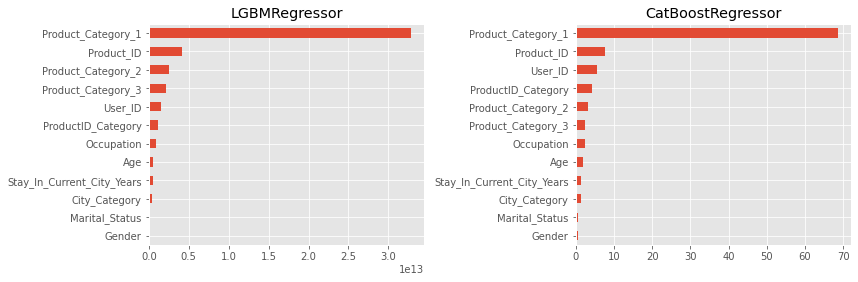

In [217]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plotImportance(lgbm)
plt.subplot(122)
plotImportance(catm)
plt.tight_layout(pad=1.);

`Test`

In [218]:
modeleval(lgbm, xtest, ytest)

2544.949216987677

In [219]:
modeleval(catm, xtest, ytest)

2555.950356648561

**`Predictions`**

In [220]:
lgbm = lgb.LGBMRegressor(random_state=seed, metrics='rmse', num_leaves=40, min_child_weight=3, n_estimators=6000,
                        learning_rate=0.07, subsample=0.65, colsample_bytree=0.7, reg_lambda=3, importance_type='gain')

catm = cat.CatBoostRegressor(random_seed=seed, eval_metric='RMSE', rsm=0.7, n_estimators=7000, learning_rate=0.12,
                             silent=True, max_depth=6, bootstrap_type='Bernoulli')

In [221]:
kfold.n_splits = 3

In [222]:
lgb_pred, lgb_tr = Predictions(lgbm, X, y)

Train RMSE: 2215.7225, Val RMSE: 2550.7244
Train RMSE: 2191.0764, Val RMSE: 2532.3733
Train RMSE: 2192.0083, Val RMSE: 2530.6949
AVG Train RMSE: 2199.6024 AVG Val RMSE: 2537.9309


In [228]:
gc.collect()

10920

In [230]:
cat_pred, cat_tr = Predictions(catm, X, y)

Train RMSE: 2382.2607, Val RMSE: 2571.8798
Train RMSE: 2392.8756, Val RMSE: 2557.5444
Train RMSE: 2393.0357, Val RMSE: 2557.5987
AVG Train RMSE: 2389.3907 AVG Val RMSE: 2562.3410


In [235]:
train_stack = np.c_[cat_tr, lgb_tr]
test_stack = np.c_[cat_pred, lgb_pred]

In [237]:
linreg = LinearRegression()

In [238]:
stack_pred = StackModels(linreg, train_stack, test_stack, y)

In [242]:
blend = 0.6 *lgb_pred + 0.4 * cat_pred

**Submission**

In [241]:
cat_df = subfile.copy()
cat_df['Purchase'] = cat_pred

In [243]:
lgb_df = subfile.copy()
lgb_df['Purchase'] = lgb_pred

In [244]:
blend_df = subfile.copy()
blend_df['Purchase'] = blend

In [245]:
stack_df = subfile.copy()
stack_df['Purchase'] = stack_pred

In [249]:
scores = pd.DataFrame(np.c_[stack_pred, blend, lgb_pred, cat_pred], 
                     columns=['Stack', 'Blend', 'LGB', 'CAT'])

In [250]:
scores

,Stack,Blend,LGB,CAT
0,15094.827148,15212.556641,14768.948242,15877.969727
1,10807.837891,10945.371094,10536.764648,11558.280273
2,7583.129883,7648.467773,7507.316406,7860.193848
3,2821.737549,3027.387451,2597.534180,3672.166992
4,2092.423828,2138.014648,2166.589111,2095.152588
...,...,...,...,...
233594,7679.370117,7689.002930,7700.061523,7672.413574
233595,5624.756836,5666.633301,5631.474121,5719.371582
233596,10046.234375,9938.140625,10225.543945,9507.036133
233597,18552.074219,18517.558594,18423.015625,18659.375000


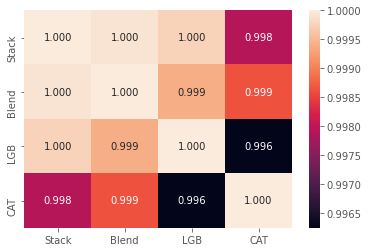

In [253]:
sns.heatmap(scores.corr(), annot=True, fmt='.3f');

In [259]:
cat_df.to_csv(os.path.join(path, './submissionfolder/cat_bl.csv'), index=False)
lgb_df.to_csv(os.path.join(path, './submissionfolder/lgb_bl.csv'), index=False)
blend_df.to_csv(os.path.join(path, './submissionfolder/blend_bl.csv'), index=False)
stack_df.to_csv(os.path.join(path, './submissionfolder/stack_bl.csv'), index=False)

**`LB Scores`**
                    
*                   `Stack               ~2524.19`  
*                   `Blend               ~2527.95`
*                   `Lgb                 ~2521.395`
*                   `Cat                 ~2553.679`